### Предметная область: Игра Dota 2

[Dota 2](https://ru.wikipedia.org/wiki/Dota_2) — многопользовательская компьютерная игра жанра [MOBA](https://ru.wikipedia.org/wiki/MOBA). Игроки играют между собой матчи. В каждом матче участвует две команды, 5 человек в каждой. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника (трон).


#### 1. Игроки выбирают героев

Всего в игре чуть более 100 различных героев (персонажей). В начале игры, команды в определенном порядке выбирают героев себе и запрещают выбирать определенных героев противнику (баны). Каждый игрок будет управлять одним героем, в рамках одного матча не может быть несколько одинаковых героев.  Герои различаются между собой своими характеристиками и способностями. От комбинации выбранных героев во многом зависит успех команды.


#### 2. Основная часть

Игроки могут получать золото и опыт за убийство чужих героев или прочих юнитов. Накопленный опыт влияет на уровень героя, который в свою очередь позволяет улучшать способности. За накопленное золото игроки покупают предметы, которые улучшают характеристики героев или дают им новые способности.

После смерти герой отправляется в "таверну" и возрождается только по прошествии некоторого времени, таким образом команда на некоторое время теряет игрока, однако игрок может досрочно выкупить героя из таверны за определенную сумму золота.

В течение игры команды развивают своих героев, обороняют свою часть поля и нападают на вражескую.


#### 3. Конец игры

Игра заканчивается, когда одна из команд разрушет определенное число "башен" противника и уничтожает трон.



### Задача: предсказание победы по данным о первых 5 минутах игры

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import math
import time
import datetime
%matplotlib inline

#### Чтение файла с признаками

In [2]:
features = pd.read_csv('data/features.csv', index_col='match_id')
objects_count = features.shape[0]
print("features.shape: ", features.shape)
features.head()

features.shape:  (97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


#### Обработка исходных данных

Удаление признаков, связанных с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
    
- `duration`: длительность
- `radiant_win`: 1, если победила команда Radiant, 0 — иначе
- Состояние башен и барраков к концу матча (см. описание полей набора данных)
    - `tower_status_radiant`
    - `tower_status_dire`
    - `barracks_status_radiant`
    - `barracks_status_dire`

In [45]:
X_train = features.drop(['duration', 'radiant_win', 'tower_status_radiant', 
                          'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis = 1)
X_train_ver2 = X_train.copy()

features_count = X_train.shape[1]

y_train = features['radiant_win'].astype('int32')
#y_train = features['radiant_win']

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
X_train.head()

X_train.shape:  (97230, 102)
y_train.shape:  (97230,)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [48]:
cnt = pd.DataFrame(X_train.count(), columns=['Count'])
cnt[cnt['Count'] < objects_count]

,Count


Если соответствующие события не успели произойти за первые 5 минут, то признаки принимают пропущенное значение:

    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля

### Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

1. **DONE**: Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. **DONE**: Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. **DONE**: Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
3. **DONE**: Какой столбец содержит целевую переменную? Запишите его название.
4. **DONE**: Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. 

Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [47]:
X_train.fillna(0, inplace=True)

In [25]:
fields_with_na = cnt[cnt['Count'] < objects_count].index
for field in fields_with_na:
    X_train_ver2[field].fillna(X_train_ver2[field].mean(), inplace=True)

Какой столбец содержит целевую переменную? Запишите его название.

**radiant_win**

Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. 

Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). 

Долго ли настраивались классификаторы? 

Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

### Метрика качества

В качестве метрики качества мы будем использовать площадь под ROC-кривой (AUC-ROC). Обратите внимание, что AUC-ROC — это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Оба алгоритма, которые будут использоваться в проекте — градиентный бустинг, и логистическая регрессия — умеют выдавать такие оценки. Для этого нужно получать предсказания с помощью функции predict_proba. Она возвращает два столбца: первый содержит оценки принадлежности нулевому классу, второй — первому классу. Вам нужны значения из второго столбца:
```python
pred = clf.predict_proba(X_test)[:, 1]
```

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
d1 = []
# for max_depth in [8, 16, 32]:
for lr in [0.3, 0.5, 0.7]:
    for n_trees in [10, 20, 30, 40, 50, 60, 70]:
        start_time = datetime.datetime.now()
        clf = GradientBoostingClassifier(n_estimators=n_trees, random_state=42, learning_rate=lr)
        clf.fit(X_train, y_train)
        sc = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=kf).mean()   
        pred = clf.predict_proba(X_train)[:, 1]
        roc_auc = roc_auc_score(y_train, pred)
        d1.append([lr, n_trees, sc, roc_auc, datetime.datetime.now() - start_time])

In [10]:
d1_df = pd.DataFrame(d1, columns=['learning_rate', 'n_trees', 'cross_val_score', 'roc_auc', 'time_elapsed'])
d1_df.pivot_table(index=['learning_rate', 'n_trees'])

cross_val_score   roc_auc
learning_rate n_trees                           
0.3           10              0.631081  0.693715
              20              0.640070  0.707831
              30              0.644606  0.716298
              40              0.646107  0.722258
              50              0.647948  0.726873
              60              0.649367  0.731164
              70              0.650334  0.735176
0.5           10              0.632994  0.695356
              20              0.642055  0.712190
              30              0.646210  0.720849
              40              0.648113  0.728116
              50              0.650273  0.733339
              60              0.650653  0.737985
              70              0.650324  0.742849
0.7           10              0.632696  0.697128
              20              0.641222  0.714645
              30              0.643659  0.723850
              40              0.645449  0.730980
              50              0.646303  0.737307
              60              0.647547  0.742657
              70              0.647496  0.747330

In [11]:
print(d1_df.cross_val_score.max())
d1_df

0.6506530906098942


,learning_rate,n_trees,cross_val_score,roc_auc,time_elapsed
0,0.3,10,0.631081,0.693715,0 days 00:01:18.944152
1,0.3,20,0.640070,0.707831,0 days 00:02:37.396168
2,0.3,30,0.644606,0.716298,0 days 00:03:53.554117
3,0.3,40,0.646107,0.722258,0 days 00:05:08.676206
4,0.3,50,0.647948,0.726873,0 days 00:06:27.814513
5,0.3,60,0.649367,0.731164,0 days 00:07:44.944800
6,0.3,70,0.650334,0.735176,0 days 00:09:01.499899
7,0.5,10,0.632994,0.695356,0 days 00:01:17.903145
8,0.5,20,0.642055,0.712190,0 days 00:02:36.821421
9,0.5,30,0.646210,0.720849,0 days 00:03:58.860585


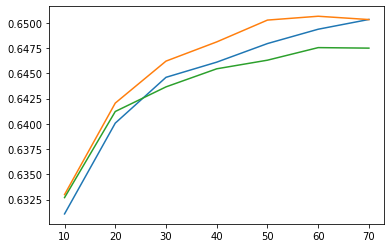

In [12]:
for lr in d1_df.learning_rate.unique():
    plt.plot(d1_df[d1_df.learning_rate == lr].n_trees, d1_df[d1_df.learning_rate == lr].cross_val_score)

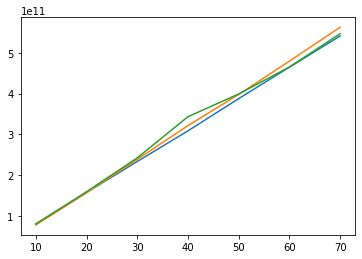

In [13]:
for lr in d1_df.learning_rate.unique():
    plt.plot(d1_df[d1_df.learning_rate == lr].n_trees, d1_df[d1_df.learning_rate == lr].time_elapsed)

Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [14]:
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators=50, random_state=42, learning_rate=0.5)
clf.fit(X_train_var2, y_train)
sc = cross_val_score(estimator=clf, X=X_train_var2, y=y_train, cv=kf).mean()   
print(sc, datetime.datetime.now() - start_time)

0.6490280777537797 0:06:26.984192


Оптимум практически достигнут при значении параметра n_estimators = 50. При дальнейшем его увеличении качество практически не растёт.
**Длительность** обучения классификатора **растёт линейно с увеличением параметра n_estimators**.

**В итоге** на CPU Intel Xeon 55555 при n_estimators=50 и learning_rate=0.5 расчёт занял 6 мин и качество составило **0.65** 

Замена пропуска на среднее значение признака увеличение качества не дала.

#### Использование алгоритма XGBoost

In [15]:
xgbc = XGBClassifier(learning_rate=0.5, n_estimators=50, random_state=42, 
                     eval_metric='rmse', use_label_encoder=False)

In [16]:
start_time = datetime.datetime.now()
xgbc.fit(X_train, y_train)
sc = cross_val_score(estimator=xgbc, X=X_train, y=y_train, cv=kf).mean()
pred = xgbc.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, pred)
print("K-fold CV average score: %.3f, roc_auc: %.3f, time elapsed: %s" % 
      (sc, roc_auc, datetime.datetime.now() - start_time))

K-fold CV average score: 0.638, roc_auc: 0.829, time elapsed: 0:01:44.946013


Алгоритм **XGBoost** показал более высокое быстродействие при сохранении качества. Результат **0.64** за 2 мин. ROC AUC = 0.83

#### Использование алгоритма XGBoost на GPU

In [ ]:
# for max_depth in [8, 16, 32]:
xgbc = XGBClassifier(tree_method='gpu_hist', gpu_id=0,
                     learning_rate=0.5, n_estimators=50, random_state=42,
                     eval_metric='rmse', use_label_encoder=False)
start_time = datetime.datetime.now()
xgbc.fit(X_train, y_train)
sc = cross_val_score(estimator=xgbc, X=X_train, y=y_train, cv=kf).mean()
pred = xgbc.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, pred)
print("K-fold CV average score: %.3f, roc_auc: %.3f, time elapsed: %s" % 
      (sc, roc_auc, datetime.datetime.now() - start_time))

**В результате** на GPU Nvidia GT 1030 при n_estimators=50 и learning_rate=0.5 расчёт занял 1 мин и качество составило **0.65** ROC AUC = 

### Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

1. **DONE** Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. **DONE** Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. **DONE** На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).
4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [ ]:
# for col in X_train.columns:
#     print(X_train[col].dtypes)

In [43]:
StandardScaler?

In [50]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,...,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,...,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,...,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,...,-0.987486,-0.594053,0.241615,-0.022021,0.269135,-1.554868,0.562864,-0.551154,-0.970428,0.837439
4,-2.529221,1.540688,-1.182811,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,...,-0.987486,1.347455,1.024223,-0.022021,0.680811,1.590976,-0.302485,0.678170,-0.970428,-0.228816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97225,1.093978,-0.575157,-0.138714,0.501314,0.834109,0.107949,0.637942,-0.537757,1.017574,-0.108632,...,-0.987486,-0.568506,0.997237,0.218879,0.228972,0.018054,0.562864,0.678170,-0.970428,-0.427189
97226,1.096181,-0.927798,-0.261549,0.501314,0.987660,0.577666,0.637942,-0.537757,1.017574,-1.309804,...,-0.987486,0.044601,-1.431548,-0.142472,-1.578386,0.542361,-0.302485,-0.551154,-0.970428,-0.253612
97227,1.098746,-0.575157,1.427430,0.501314,0.292267,-1.309820,-1.131661,-0.537757,-0.578083,-1.309804,...,1.769891,-0.645145,1.928271,0.580230,-1.578386,-1.030561,-2.033183,0.678170,0.437788,-0.204019
97228,1.098952,-0.575157,1.488848,-0.398181,-0.173682,-0.822866,-0.578660,-0.537757,2.613231,-0.909413,...,-0.987486,-0.364137,1.995737,-0.323147,0.259094,1.066668,-0.302485,0.678170,0.437788,-0.873528


Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [33]:
LogisticRegression?
# LogisticRegression(
#     penalty='l2',
#     *,
#     dual=False,
#     tol=0.0001,
#     C=1.0,
#     fit_intercept=True,
#     intercept_scaling=1,
#     class_weight=None,
#     random_state=None,
#     solver='lbfgs',
#     max_iter=100,
#     multi_class='auto',
#     verbose=0,
#     warm_start=False,
#     n_jobs=None,
#     l1_ratio=None,
# )

# clf = LogisticRegression(random_state=0).fit(X, y)
# clf.predict(X[:2, :])

# clf.predict_proba(X[:2, :])

In [53]:
d1 = []
for C in [0.1, 1, 10, 50]:
    start_time = datetime.datetime.now()
    clf = LogisticRegression(penalty='l2', C=C, random_state=42)
    clf.fit(X_train_scaled, y_train)
    sc = cross_val_score(estimator=clf, X=X_train_scaled, y=y_train, cv=kf).mean()   
    pred = clf.predict_proba(X_train_scaled)[:, 1]
    roc_auc = roc_auc_score(y_train, pred)    
    d1.append([C, sc, roc_auc, datetime.datetime.now() - start_time])
d1_df = pd.DataFrame(d1, columns=['C', 'cross_val_score', 'roc_auc', 'time_elapsed'])
d1_df

,C,cross_val_score,roc_auc,time_elapsed
0,0.1,0.655374,0.71799,0 days 00:00:04.465591
1,1.0,0.655466,0.71799,0 days 00:00:04.322306
2,10.0,0.655456,0.71799,0 days 00:00:04.385336
3,50.0,0.655446,0.71799,0 days 00:00:04.363967


Как оно соотносится с качеством градиентного бустинга? **Чем вы можете объяснить эту разницу?** Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Hаилучшее качество получилось: cross_val_score=0.65, roc_auc=0.72 - что **сопоставимо с качеством градиентного бустинга**

(только на XGBoost ROC AUC был выше - 0.83).

Но время работы значительно меньше - всего 4 сек.

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [56]:
categ_features = ['lobby_type']
for i in range(1, 6):
    categ_features.append('r' + str(i) + '_hero')
    categ_features.append('d' + str(i) + '_hero')
X_train_ver3 = X_train.drop(categ_features, axis = 1)
X_train[categ_features]

,lobby_type,r1_hero,d1_hero,r2_hero,d2_hero,r3_hero,d3_hero,r4_hero,d4_hero,r5_hero,d5_hero
match_id,,,,,,,,,,,
0,7,11,4,67,42,29,21,20,37,105,84
1,0,42,39,49,88,67,79,37,7,26,12
2,7,33,22,98,66,20,86,27,29,4,80
3,1,29,96,30,48,75,15,37,102,41,20
4,7,13,26,27,69,30,22,72,25,93,8
...,...,...,...,...,...,...,...,...,...,...,...
114402,1,47,26,7,19,1,93,21,3,71,28
114403,0,43,72,26,75,4,5,29,20,110,98
114404,1,98,28,11,39,112,55,81,59,50,31


In [58]:
X_train_ver3_scaled = pd.DataFrame(scaler.fit_transform(X_train_ver3))
X_train_ver3_scaled

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,-2.544364,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,-0.332256,-0.625222,...,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,0.578881,0.732454,...,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,-0.332256,0.224676,...,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-1.243393,-1.170813,...,-0.987486,-0.594053,0.241615,-0.022021,0.269135,-1.554868,0.562864,-0.551154,-0.970428,0.837439
4,-2.529221,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,-1.243393,-1.008757,...,-0.987486,1.347455,1.024223,-0.022021,0.680811,1.590976,-0.302485,0.678170,-0.970428,-0.228816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97225,1.093978,0.501314,0.834109,0.107949,0.637942,-0.537757,1.017574,-0.108632,-1.243393,-1.032165,...,-0.987486,-0.568506,0.997237,0.218879,0.228972,0.018054,0.562864,0.678170,-0.970428,-0.427189
97226,1.096181,0.501314,0.987660,0.577666,0.637942,-0.537757,1.017574,-1.309804,-0.332256,-0.765671,...,-0.987486,0.044601,-1.431548,-0.142472,-1.578386,0.542361,-0.302485,-0.551154,-0.970428,-0.253612
97227,1.098746,0.501314,0.292267,-1.309820,-1.131661,-0.537757,-0.578083,-1.309804,0.578881,0.465961,...,1.769891,-0.645145,1.928271,0.580230,-1.578386,-1.030561,-2.033183,0.678170,0.437788,-0.204019
97228,1.098952,-0.398181,-0.173682,-0.822866,-0.578660,-0.537757,2.613231,-0.909413,1.490017,1.377080,...,-0.987486,-0.364137,1.995737,-0.323147,0.259094,1.066668,-0.302485,0.678170,0.437788,-0.873528


In [59]:
d1 = []
for C in [0.1, 1, 10]:
    start_time = datetime.datetime.now()
    clf = LogisticRegression(penalty='l2', C=C, random_state=42)
    clf.fit(X_train_ver3_scaled, y_train)
    sc = cross_val_score(estimator=clf, X=X_train_ver3_scaled, y=y_train, cv=kf).mean()   
    pred = clf.predict_proba(X_train_ver3_scaled)[:, 1]
    roc_auc = roc_auc_score(y_train, pred)    
    d1.append([C, sc, roc_auc, datetime.datetime.now() - start_time])
d1_df = pd.DataFrame(d1, columns=['C', 'cross_val_score', 'roc_auc', 'time_elapsed'])
d1_df

,C,cross_val_score,roc_auc,time_elapsed
0,0.1,0.654983,0.717847,0 days 00:00:04.053584
1,1.0,0.655004,0.717846,0 days 00:00:04.004401
2,10.0,0.655024,0.717847,0 days 00:00:03.989382


На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [74]:
heroes = []
for col in categ_features:
    heroes.extend(X_train[col].unique())
N = len(np.unique(heroes))
print(N)

109


Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данное преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.


##### Код для формирования "мешка слов" по героям
```python
# N — количество различных героев в выборке
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in xrange(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p + 1)] - 1] = -1
```

In [85]:
X_pick = np.zeros((objects_count, N))

for i, match_id in enumerate(X_train.index):
    for p in range(5):
        X_pick[i, X_train.ix[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, X_train.ix[match_id, 'd%d_hero' % (p + 1)] - 1] = -1
X_pick        

AttributeError: 'numpy.ndarray' object has no attribute 'ix'

In [86]:
X_train.index

Int64Index([     0,      1,      2,      3,      4,      5,      8,      9,
                11,     12,
            ...
            114396, 114397, 114399, 114400, 114401, 114402, 114403, 114404,
            114405, 114406],
           dtype='int64', name='match_id', length=97230)

### Проверка финальной модели

После того как вы провели все эксперименты и выбрали лучшую модель, можете проверить ее качество на тестовых матчах.  В отличие от основного набора матчей, в тестовых матчах есть только та информация, которая известна на момент первых 5 игровых минут, результат матча — неизвестен. Таблица признаков для тестовых матчей — `features_test.csv`.

Для всех матчей из тестового набора предскажите вероятность победы Radiant, запишите предсказания в CSV файл с колонками `match_id` (идентификатор матча) и `radiant_win` — предсказанная вероятность. Файл с предсказаниями должен выглядеть примерно следующим образом:

```
match_id,radiant_win
1,0.51997370502
4,0.51997370502
15,0.51997370502
...
```

Отправьте решение на Kaggle в соревнование: Dota 2: Win Probability Prediction.

Ссылка на соревнование: [Dota 2: Win Probability Prediction](https://kaggle.com/join/coursera_ml_dota2_contest)

In [17]:
# answer = 
# print(answer)
# with open('lab_answ/final_statement.csv', 'w') as outfile:
#     outfile.write(answer)

### Что еще попробовать?

Разумеется, можно попробовать еще очень много разных идей, которые помогут вам получить еще более высокий результат на kaggle. Вот лишь несколько возможных вариантов:
1. Про каждого из игроков есть достаточно много показателей: максимальный опыт, число смертей и т.д. (см. список выше). Можно попробовать просуммировать или усредних их, получив агрегированные показатели для всей команды.
2. В сырых данных (файл matches.jsonlines.bz2) содержится очень много информации, которую мы пока не использовали. Вы можете, например, составить "мешки слов" для покупок различных предметов (то есть кодировать информацию о том, сколько раз каждая команда покупала тот или иной предмет). Обратите внимание, что при этом вы можете получить слишком большое количество признаков, для которых может иметь смысл сделать понижение размерности с помощью метода главных компонент.
3. Можно сформировать признаки про изменения способностей героев в течение матча (ability_upgrades).
4. В этом задании используются только градиентный бустинг и логистическая регрессия — но ведь мы изучали и другие модели! Можно попробовать метод k ближайших соседей, SVM, случайный лес и так далее.

### Использование нейронной сети

#### Проверка GPU

In [18]:
# if torch.cuda.is_available():
#     torch.cuda.set_device(0)
#     torch.cuda.current_device()
#     torch.cuda.device(0)
#     torch.cuda.device_count()
#     torch.cuda.get_device_name(0)
# else:
#     device = torch.device("cpu")
    
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
# Assuming that we are on a CUDA machine, this should print a CUDA device:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )
# print(device)

Using device: cpu



#### Загрузчики данных

In [19]:
X_train_ds = torch.tensor(np.array(X_train))
y_train_ds = torch.tensor(np.array(y_train))

trainset = TensorDataset(X_train_ds, y_train_ds)
  
# implementing dataloader on the dataset 
trainloader = DataLoader(trainset, batch_size=5, shuffle=True)
  
# for i in dataloader:
#     print(i)
#     break

#### Определение нейронной сети.

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # Конструктор суперкласса
        
        # Описание слоёв:
        nodes2 = features_count // 3
        self.fc1 = nn.Linear(features_count, nodes2, bias=False) # Полносвязный слой первый аргумент — определение 
                                              # количества узлов в i-том слое, а второй — 
                                              # количество узлов в i+1 слое
        nodes3 = nodes2 // 4
        self.fc2 = nn.Linear(nodes2, nodes3, bias=False)     # Полносвязный слой
        self.fc3 = nn.Linear(nodes3, 1, bias=False)          # Полносвязный слой

    # Функция, описывающая поток данных при обучении и предсказании
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# dataset = ld.load()
# data_iter = Data.DataLoader(dataset, batch_size=168, shuffle=True)
data_iter = trainloader
# net = model.VGG_19()
# summary(net, (3, 224, 224), device="cpu")
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, dampening=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
for epoch in range(5):
    print("epoch:", epoch + 1)
    train_loss = 0
    for i, data in enumerate(data_iter, 0):
        x, y = data
        x = x.float()
        y = y.long()
        print(x.dtype)
        optimizer.zero_grad()
        out = net(x)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 100 == 99:
            print("loss:", train_loss / 100)
            train_loss = 0.0

NameError: name 'net' is not defined

#### Отправляем сеть на GPU:

In [ ]:
net = Net().double()
net.to(device)

#### Определим функцию потерь и оптимизатор

In [ ]:
loss_func = nn.CrossEntropyLoss()  # Функция потерь. 

# Оптимизатор SGD - Стохастический градиентный оптимизатор. 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [ ]:
loss_func?

#### Обучение сети

In [ ]:
start_time = datetime.datetime.now()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

# #         labels = labels.float()
#         loss = loss_func(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Time elapsed:', datetime.datetime.now() - start_time)

#### Проверка использования видеопамяти

In [ ]:
!nvidia-smi

#### Сохраняем обученную модель

In [ ]:
PATH = './my_final_statement.pth'
torch.save(net.state_dict(), PATH)

#### Тестирование сети

In [ ]:
net = Net()

# Загрузка параметров модели из файла
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)    # что значит _,  ?

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


#### Посмотрим, как сеть работает на всем наборе данных.

In [ ]:
correct = 0
total = 0
with torch.no_grad():   # что значит no_grad() ?
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))